## Analyze integrative CD8 T cell single-cell transcriptomics data from synovial tissue, synovial fluid, and blood together from patients with RA. GzmK and GzmB mark transcriptionally distinct T cell subsets.
## Fan Zhang

In [32]:
library(magrittr)
library(gridExtra)
library(ggthemes)
library(pheatmap)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(scales)
library(dplyr)
library(RColorBrewer)
library(patchwork)
library(MASS)
library(matrixStats)
library(viridis)
library(pbapply)
library(parallel)
library(Seurat)
library(harmony)
library(grid)
library(ComplexHeatmap)
library(circlize)
library(scico)
library(DESeq2)

meta_colors <- list(
    
      "source" = c( 
        "tissue" = "#BD0026",
        "PBMC" = "#7570B3",
        "fluid" = "#FEB24C"
      ),

    "cluster_new" = c(
        "1" = "#999999", 
        # Gzmk
       "2" = "#FDB863",   
       "3" = "#FFD92F",
       "4"  ="#E08214",
        # Gzmb
       "6" = "#084594",
       "7" = "#74ADD1",
        # GzmbGzmk
       "5" = "#74C476"
        ),

  "itc" = c(
        "CD4" = "#0072B2", 
        "CD8" = "#56B4E9",
        "MAIT" = "#009E73",
        "NK" = "#606060",
        "iNKT" = "#CC79A7", 
        "Vd1" = "#E69F00",
        "Vd2" = "#D55E00",
        "NA" = "lightgrey"
    ),
    
 "datast" = c(
    "amp phase I" = "#00441B",
    "amp phase 1" = "#00441B",
    "bwh002" ="#FFFFBF",
    "bwh054" ="#E6F598", 
    "bwh075" ="#ABDDA4", 
    "bwh076" ="#66C2A5",
    "PBMC_v2 (ITC)" = "#A50F15",
    "PBMC_v3" = "#000000"
    )
)

In [14]:
pseudobulk_deseq2 <- function(dge_formula, meta_data, counts_df, verbose=TRUE, 
                   min_counts_per_sample=10, present_in_min_samples=5) {
    ## filter low expressed genes
    genes_keep <- which(rowSums(counts_df >= min_counts_per_sample) >= present_in_min_samples)
    if (verbose) {
        message(sprintf('Filtered out %d genes, analyzing %d genes', nrow(counts_df) - length(genes_keep), length(genes_keep)))
    }
    counts_df <- counts_df[genes_keep, ]
    
    ## assume that the first variable in formula is the main contrast variable
    all_vars <- unlist(strsplit(tail(as.character(dge_formula), 1), split = ' \\+ '))
    if (verbose) {
        message(sprintf('All vars: %s', paste(all_vars, collapse = ', ')))
    }
    contrast_var <- head(all_vars, 1)
    if (verbose) {
        message(sprintf('Contrast var: %s', contrast_var))
    }
    Reduce(rbind, lapply(unique(meta_data[[contrast_var]]), function(foreground_id) {
        if (verbose) {
            message(foreground_id)      
        }
        suppressMessages({suppressWarnings({
            ## setup design 
            design <- meta_data            
            design[[contrast_var]] <- factor(ifelse(design[[contrast_var]] == foreground_id,
                                               paste0('cluster_', foreground_id), 
                                               'background'))
            
            ## background clusters should not be treated as independent observations
            res <- collapse_counts(counts_df, design, all_vars)
            design <- res$meta_data
            counts_df <- res$counts_mat
            
            ## Do DGE with DESeq2
            dds <- DESeqDataSetFromMatrix(
                countData = counts_df,
                colData = design,
                design = dge_formula) %>% 
                DESeq2::DESeq()

            print(DESeq2::resultsNames(dds))
            
            ## Get results 
            contrast_name <- grep('cluster.*_vs_background', resultsNames(dds), value = TRUE)
            dge_res <- results(dds, name = contrast_name) %>% 
                    data.frame() %>% 
                    tibble::rownames_to_column('feature') %>% 
                    dplyr::arrange(-stat) %>% 
                    dplyr::mutate(group = foreground_id)
        })})
        return(dge_res)
    })) %>% 
    dplyr::select(group, feature, everything())

}

In [15]:
commonTheme = list(labs(color="Density",fill="Density",
                        x="UMAP1",
                        y="UMAP2"),
                  theme_bw(base_size = 25) +
                  theme(
                    legend.position = "none",
                    panel.grid = element_blank(),
                    plot.title = element_text(color="black", size=22, face = "italic")
                  ))

# Integrateive CD8 T cell single-cell data

In [16]:
tis_flui_blov2v3 <- readRDS("tis_flui_blov2v3.rds")

In [17]:
class(tis_flui_blov2v3)
table(tis_flui_blov2v3@meta.data$dataset)

[1] "seurat"
attr(,"package")
[1] "Seurat"


    amp  bwh002  bwh054  bwh075  bwh076   fluid    PBMC PBMC_v3 
    428     309     147     303     308    5957    1788    2362 

In [19]:
# extract data 
tis_flui_blov2v3_exp <- tis_flui_blov2v3@data
tis_flui_blov2v3_meta = data.frame(
  name = rownames(tis_flui_blov2v3@meta.data),
  UMAP1 = tis_flui_blov2v3@dr$umap@cell.embeddings[,1],
  UMAP2 = tis_flui_blov2v3@dr$umap@cell.embeddings[,2],
  dataset = tis_flui_blov2v3@meta.data$dataset,
  cluster = tis_flui_blov2v3@meta.data[, "res.0.6"],
  nGene = tis_flui_blov2v3@meta.data[, "nGene"],
  nUMI = tis_flui_blov2v3@meta.data[, "nUMI"]
)

tis_flui_blov2v3_meta$dataset <- as.character(tis_flui_blov2v3_meta$dataset)
tis_flui_blov2v3_meta$dataset[which(tis_flui_blov2v3_meta$dataset == "PBMC")] <- "PBMC_v2 (ITC)"
tis_flui_blov2v3_meta$dataset[which(tis_flui_blov2v3_meta$dataset == "amp")] <- "amp phase I"
all(colnames(tis_flui_blov2v3_exp) == tis_flui_blov2v3_meta$name)

[1] TRUE

In [20]:
rm(tis_flui_blov2v3)

In [27]:
# saveRDS(tis_flui_blov2v3_meta, "tis_flui_blov2v3_meta_2021-07-28.rds")
tis_flui_blov2v3_meta <- readRDS("/data/srlab1/fzhang/results/2019_03_01_CD8_Brenner_data/2019_03_01_CD8_Brenner_data/tis_flui_blov2v3_meta_2021-07-28.rds")

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


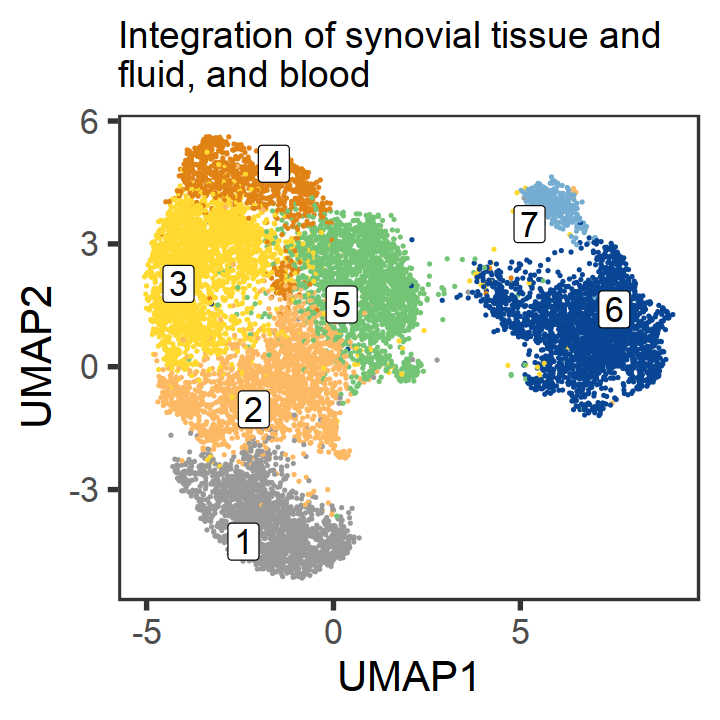

In [14]:
# Find cluster center
cluster_center <- tis_flui_blov2v3_meta %>%
                  group_by(cluster_new) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

options(repr.plot.height = 6, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = tis_flui_blov2v3_meta[sample(nrow(tis_flui_blov2v3_meta)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "cluster_new"),
    size = 1.2, stroke = 0.001, shape = 21
  ) +
  geom_label_repel(
    data = cluster_center,
    aes(x = UMAP1, y = UMAP2, label = cluster_new),
    size = 7, color = "black",
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.05, "lines")
  ) +
  scale_fill_manual(values = meta_colors$cluster_new, name = "") +\
  labs(title = "Integration of synovial tissue and\nfluid, and blood") +
  theme_bw(base_size = 25) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22)
  )
ggsave(file = paste("tis_flui_blov2v3_cluster", ".png", sep = ""), width = 6, height = 6, dpi = 300)


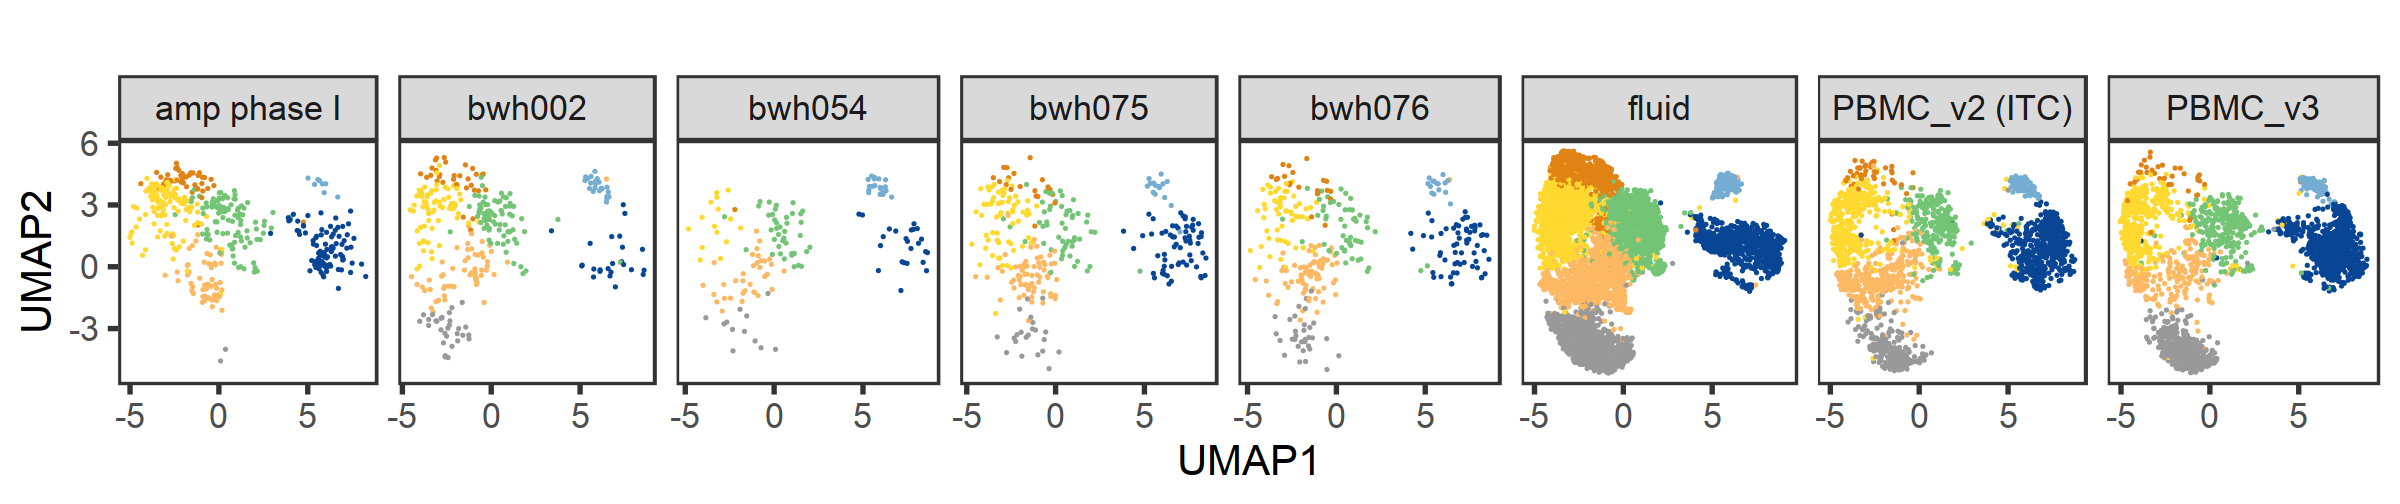

In [29]:
options(repr.plot.height = 4.2, repr.plot.width = 20)
ggplot() +
  geom_point(
    data = tis_flui_blov2v3_meta[sample(nrow(tis_flui_blov2v3_meta)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "cluster_new"),
    size = 1.2, stroke = 0.001, shape = 21
  ) +
  scale_fill_manual(values = meta_colors$cluster_new, name = "") +
  facet_grid( ~ dataset, scales = "free", space = "free_x") +
  labs(title = "") +
  theme_bw(base_size = 25) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22)
  )
ggsave(file = paste("by_dataset", ".png", sep = ""), width = 20, height = 4.2, dpi = 300)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."

null device 
          1

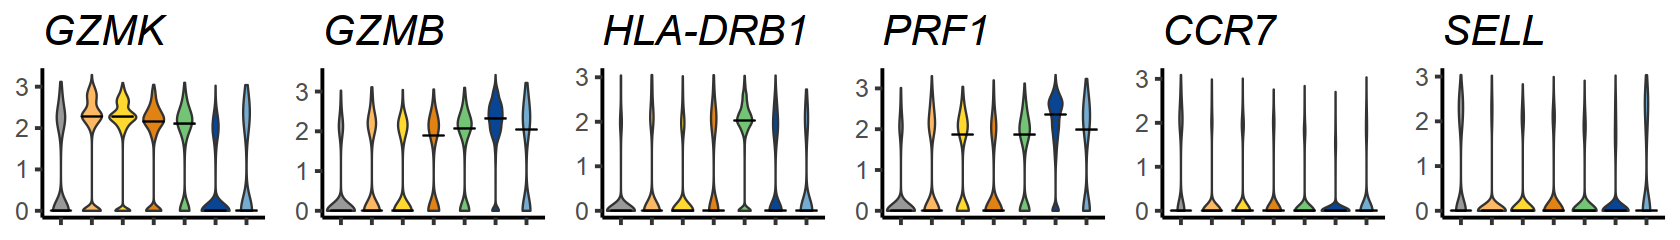

In [31]:
plot_gene <- c("GZMK", "GZMB", "HLA-DRB1", "PRF1", "CCR7", "SELL")
plot_gene %in% rownames(tis_flui_blov2v3_exp)

myplots <- list()
options(repr.plot.height = 2, repr.plot.width = 14)
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
    
  ind <- paste("p", i, sep = "")
  ind <- 
    ggplot(
      data    = tis_flui_blov2v3_meta,
      mapping = aes(x = cluster_new, y = gene, fill = cluster_new)
    ) +
    geom_violin(
        position = position_dodge(width = 2) 
    ) +
    stat_summary(
       fun = median, fun.min = median, fun.max = median,
       aes(group=cluster_new), position=position_dodge(0.9), 
       geom = "crossbar", width = 0.7, size = 0.2
    ) +
    scale_fill_manual(values = meta_colors$cluster_new, name = "") +
    guides(
      fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_classic(base_size = 18) +
    theme(
      plot.title = element_text(color="black", size=25, face = "italic"), # face="bold.italic"
      strip.text.x = element_blank(),
      axis.text.x=element_blank(),
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}


all <- do.call("grid.arrange", c(myplots, ncol = 6))
ggsave(file = paste("violin_genes", ".pdf", sep = ""), all, width = 14, height = 2, dpi = 300)
dev.off()

In [38]:
tis_flui_blov2v3_meta$dataset_new <- tis_flui_blov2v3_meta$dataset
tis_flui_blov2v3_meta$dataset_new[which(tis_flui_blov2v3_meta$dataset_new %in% c("PBMC_v2 (ITC)", "PBMC_v3"))] <- "PBMC"
tis_flui_blov2v3_meta$dataset_new[which(tis_flui_blov2v3_meta$dataset_new %in% c("amp phase I", "bwh002", "bwh054", "bwh075", "bwh076"))] <- "tissue"
table(tis_flui_blov2v3_meta$dataset_new)
tis_flui_blov2v3_meta$dataset_new <- factor(tis_flui_blov2v3_meta$dataset_new, levels = c("tissue", "fluid", "PBMC"))


  PBMC  fluid tissue 
  4150   5957   1495 

In [22]:
cluster_detail <- table(tis_flui_blov2v3_meta$cluster_new, tis_flui_blov2v3_meta$dataset)
cluster_detail <- as.matrix(cluster_detail)
cluster_detail

write.table(cluster_detail, file = paste("cluster_dataset_cell_number_figure2", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")



   
    amp phase I bwh002 bwh054 bwh075 bwh076 fluid PBMC_v2 (ITC) PBMC_v3
  1           2     30     12     22     32  1000           235     441
  2          58     55     34     66     72  1122           310     195
  3         117     70     15     64     55  1194           400     408
  4          45     32      1     19     21   701            44      36
  5         103     74     40     54     53  1093           230     256
  6          95     24     24     62     60   728           495     956
  7           8     24     21     16     15   119            74      70

## Benchmarking several differential expression analyses. Identify GzmK+ gene signature: high GzmK, low cytotoxicity

In [16]:
exp_new <- tis_flui_blov2v3_exp[,which(colnames(tis_flui_blov2v3_exp) %in% meta_new$name)] 
all(colnames(exp_new) == meta_new$name)
genes_exclude <- grep("^MT-|^MTRNR|^RPL|^RPS|MALAT1|MIR-", row.names(exp_new), value = TRUE)
mega_marker <- wilcoxauc(exp_new[-which(rownames(exp_new) %in% genes_exclude), ], meta_new$megacluster)

[1] TRUE

In [36]:
x <- mega_marker %>%
  group_by(group) %>%
  top_n(50, wt = auc) 

In [9]:
## Save the gzmk gene and gzmb gene
gzmk_sig <- x[which(x$group == "GzmK+" & x$auc > 0.65),]$feature
gzmb_sig <- x[which(x$group == "GzmB+" & x$auc > 0.65),]$feature

# saveRDS(gzmk_sig, "gzmk_sig.rds")
# saveRDS(gzmb_sig, "gzmb_sig.rds")

In [52]:
# Claculate mean, sd, % expressing cells, wilcox p, ttest p, and log2FC.
auroc <- function(score, cls) {
  n1 <- sum(!cls)
  n2 <- sum(cls)
  U <- sum(rank(score)[!cls]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

get_markers <- function(log2cpm, cell_clusters) {
  # Compute statistics for each cluster.
  dat_marker <- rbindlist(pblapply(
    X = rownames(log2cpm),
    cl = 20,
    FUN = function(gene_name) {
      gene      <- as.numeric(log2cpm[gene_name,])
      rbindlist(lapply(unique(cell_clusters), function(cell_cluster) {
        ix <- cell_clusters == cell_cluster
        x <- gene[ix]
        x_mean <- mean(x)
        x_sd   <- sd(x)
        x_pct_nonzero <- sum(x > 0) / length(x)
        y <- gene[!ix]
        y_mean <- mean(y)
        y_sd   <- sd(y)
        y_pct_nonzero <- sum(y > 0) / length(y)
        test_w <- wilcox.test(x, y, alternative = "two.sided")
        test_t <- t.test(x, y, alternative = "two.sided")
        data.frame(
          "gene"              = gene_name,
          "cluster"           = cell_cluster,
          "wilcox_pvalue"     = test_w$p.value,
          "ttest_pvalue"      = test_t$p.value,
          "auc"               = auroc(gene, ix),
          "pct_nonzero"       = x_pct_nonzero,
          "pct_nonzero_other" = y_pct_nonzero,
          "log2FC"            = x_mean - y_mean,
          "mean"              = x_mean,
          "sd"                = x_sd,
          "mean_other"        = y_mean,
          "sd_other"          = y_sd
        )
      }))
    }
  ))
  # Check if the mean is highest in this cluster.
  dat_marker[
    ,
    mean_highest := mean >= max(mean),
    by = gene
  ]
  dat_marker[
    ,
    pct_nonzero_highest := pct_nonzero >= max(pct_nonzero),
    by = gene
  ]
  return(dat_marker)
}


# Test each cluster against all cells.
dat_marker <- get_markers(
    as.data.frame(as.matrix(exp_new)), 
    meta_new$megacluster
)

fan <- dat_marker %>%
  group_by(cluster) %>%
  top_n(50, wt = auc) 

fan_gene <- fan[-which(fan$gene %in% genes_exclude),]
min(fan_gene[which(fan_gene$cluster == "GzmK+"),]$auc)

In [53]:
saveRDS(dat_marker, "dat_marker_2020-08-28.rds")

## Pseudo-bulk DEG

In [62]:
resTest <- c("megacluster")
system.time({
    obj <- lapply(resTest, function(x){
        a <- presto::collapse_counts(
            counts_mat = tis_flui_blov2v3_exp,
            meta_data = meta_new,
            varnames = c(x, 'sample'), # "dataset"
            keep_n = TRUE
        )
        a$counts_mat <- a$counts_mat[which(rowSums(a$counts_mat) != 0), ]
        a$meta_data$logUMI <- log(colSums(a$counts_mat))
        a$meta_data$Cluster <- a$meta_data[, x]
        return(a)
    })
})

   user  system elapsed 
  0.259   0.072   0.334 

In [56]:
gzmk_gzmb_save <- dat_marker[which(dat_marker$gene %in% gzmk_gzmb_gene),]
"GZMK" %in% gzmk_gzmb_save$gene
gzmk_gzmb_save <- gzmk_gzmb_save[which(gzmk_gzmb_save$pct_nonzero_highest == "TRUE"),]
gzmk_gzmb_save <- gzmk_gzmb_save[order(gzmk_gzmb_save$cluster),]
dim(gzmk_gzmb_save)

write.table(gzmk_gzmb_save, file = paste("table_gzmk_gzmb_gene_list", ".txt", sep = ""),
             row.names=T,col.names=T, quote = F, sep = "\t")

[1] TRUE

[1] 71 14

In [75]:
# deseq2_mega_gene <- pseudobulk_deseq2(~Cluster + dataset, obj[[1]]$meta_data, obj[[1]]$counts_mat[tis_flui_blov2v3@var.genes,], verbose = TRUE)
# saveRDS(deseq2_mega_gene, "deseq2_mega_gene.rds")

## Show the GzmK and GzmB gene lists

In [4]:
all(colnames(exp_new) == meta_new$cell)

In [3]:
fan_gzmb_gene <- readRDS("final_gzmb.rds")
final_gzmk <- readRDS("final_gzmk.rds")
gzmk_gzmb <- as.character(union(fan_gzmb_gene, final_gzmk)

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



png 
  2

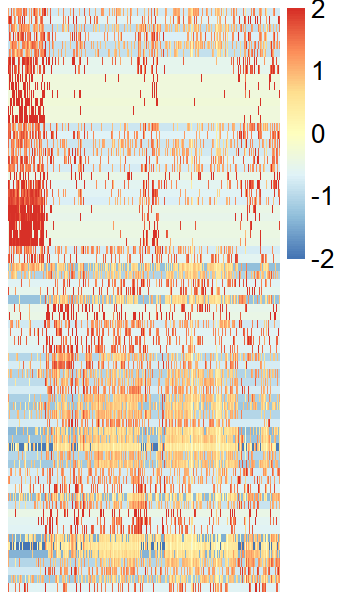

In [177]:
exp_plot <- exp_new[gzmk_gzmb,
mat_breaks <- seq(min(exp_plot), max(exp_plot), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
mat_breaks <- quantile_breaks(exp_plot, n = 10)


scale_rows <- function(x) t(scale(t(x)))
exp_scale <- scale_rows(exp_plot) # Z-score
exp_scale[exp_scale > 2] <- 2
exp_scale[exp_scale < -2] <- -2

options(repr.plot.width = 3, repr.plot.height = 5)
x <- pheatmap(
  mat = exp_scale,
  border_color = NA,
  show_rownames = F,
  show_colnames = F,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  treeheight_row = 0, 
  treeheight_col = 0,
  fontsize = 15,
  fontsize_row = 15
)

save_pheatmap_pdf <- function(x, filename, width=3, height=5) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(x, "heatmap_gzmk_gzmb.pdf")

In [332]:
col_fun <- scico(30, palette = 'vik')   # colorRamp2(c(-2, 0, 2), c("#001260", "#EEEBE2", "#601200"))
# col_fun <- brewer.pal(9, "RdBu")

## Differential expression analysis

In [17]:
# library(presto)
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MTRNR-|MIR-", row.names(tis_flui_blov2v3_exp), value = TRUE)
marker <- wilcoxauc(tis_flui_blov2v3_exp, tis_flui_blov2v3_meta$cluster_new)
saveRDS(marker, "tis_flui_blov2v3_marker.rds")

In [412]:
x <- marker %>%
  group_by(group) %>%
  top_n(5, wt = auc) 
x[1:4,]
min(x$auc)
min(x$pct_in)

feature group avgExpr   logFC     statistic auc       pval         
1 CCR7    1     0.9365022 0.6935173 11562909  0.6632058 7.858446e-244
2 EEF1B2  1     2.3888711 0.3678650 11933751  0.6844760 1.134406e-135
3 EIF3E   1     2.0180748 0.5253699 11881554  0.6814821 3.365241e-134
4 IL7R    1     1.9473581 0.7962940 12189688  0.6991556 6.012463e-173
  padj          pct_in   pct_out 
1 2.298595e-240 42.95378 12.52544
2 7.807381e-133 94.58850 87.39316
3 2.187407e-131 85.62570 69.06797
4 5.862151e-170 80.83427 50.53928

[1] 0.6056978

[1] 42.95378

null device 
          1

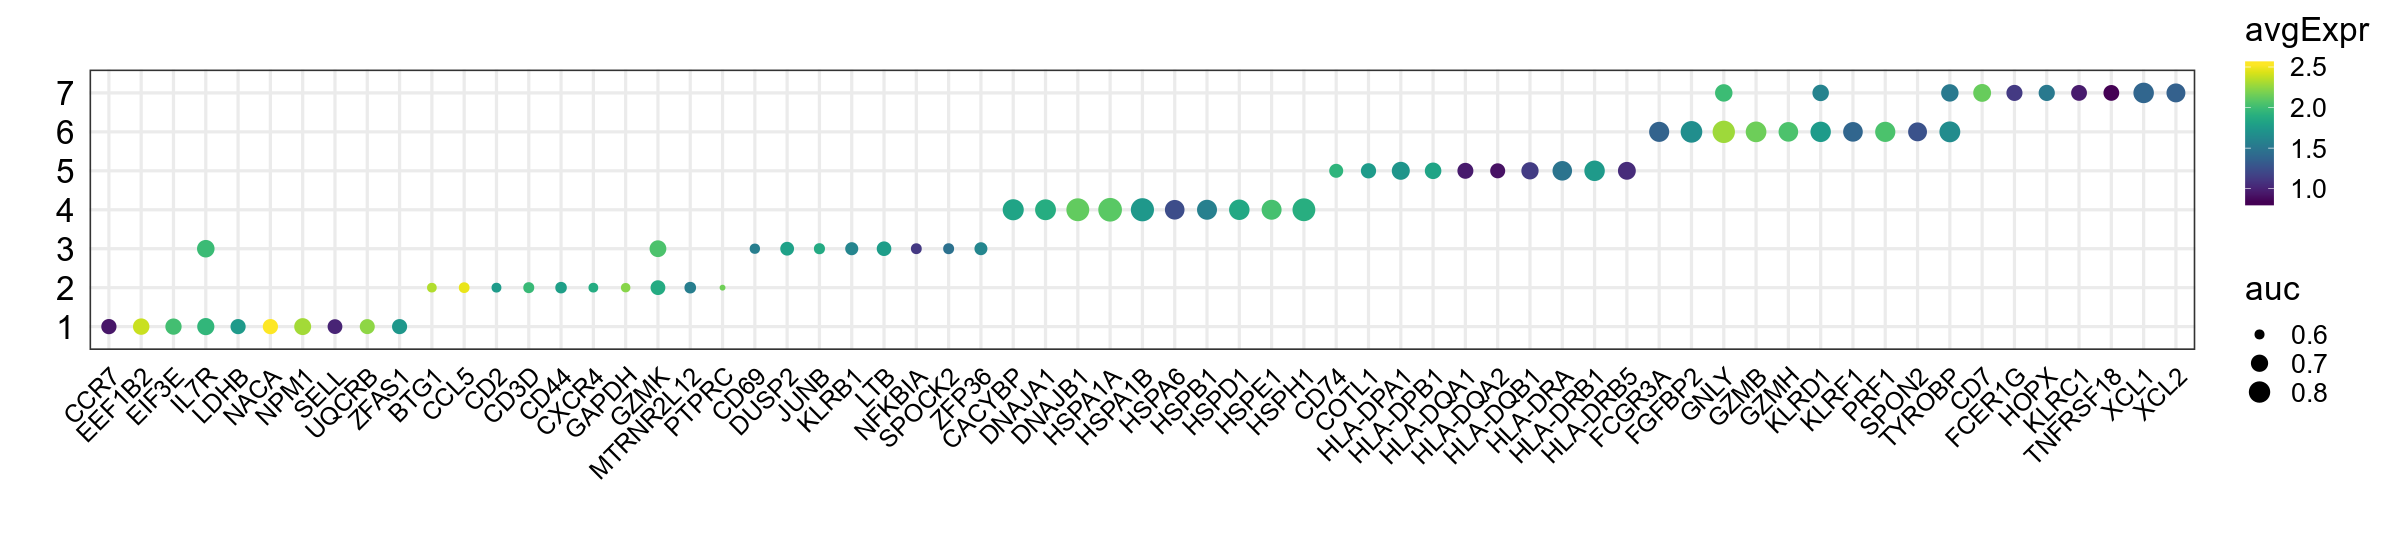

In [86]:
# x <- x[-which(x$feature %in% genes_exclude), ]
x$feature <- factor(x$feature, levels=unique(as.character(x$feature)))


options(repr.plot.height = 4.5, repr.plot.width = 20)
ggplot(x, aes(feature, group)) +
  geom_point(aes(size = auc, colour=avgExpr)) + 
#   geom_vline(xintercept = c(10.5,20.5)) +
  ggtitle("") +
  scale_color_viridis(option = "D") +
  theme_bw(base_size = 20) +
  labs(x = "", y = "", size = "auc", colour = "avgExpr") +
  theme(axis.text.x = element_text(size = 15, angle = 45, hjust = 1, color = "black"),
        axis.text.y = element_text(size = 20, color = "black"),
        title = element_text(size=20),
#         panel.grid = element_blank(),
        axis.ticks = element_blank()   
       )

dev.off()

[1] TRUE

[1] TRUE

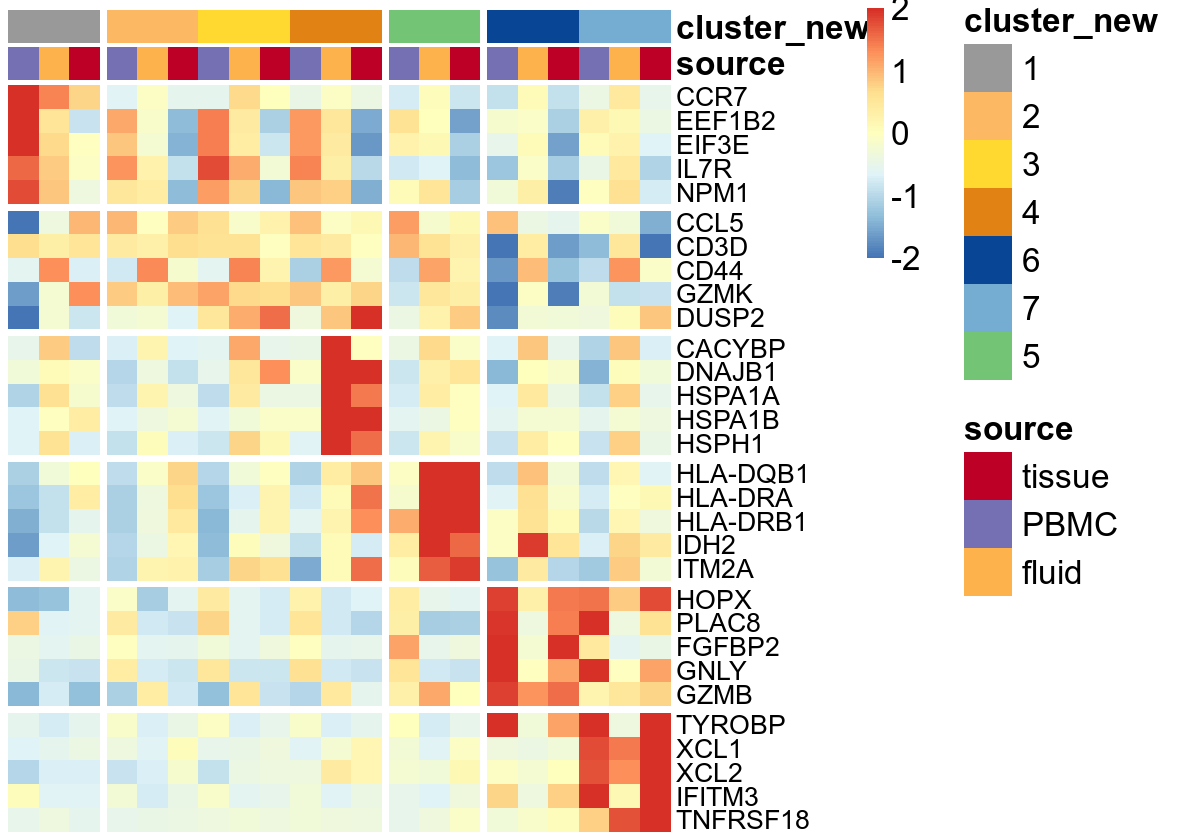

In [518]:
## Heatmap of marker genes
# Show genes with auc > 0.6 and percent of expressing cells > 40%

genes <- unique(x$feature)
# genes <- c('CCR7','EEF1B2','EIF3E','IL7R','NPM1', 'CCL5','CD3D','CD44','GZMK', 'DUSP2', 'CACYBP','DNAJB1', 'HSPA1A','HSPA1B', 'HSPH1', 'HLA-DQB1','HLA-DRA','HLA-DRB1',
#            "IDH2", "ITM2A", "HOPX", "PLAC8", 'FGFBP2','GNLY','GZMB', 'TYROBP','XCL1','XCL2', "IFITM3", "TNFRSF18"
#           )


exp_heat <- as.matrix(tis_flui_blov2v3_exp[genes,])
all(colnames(exp_heat) == tis_flui_blov2v3_meta$cell)
exp_heat <- t(exp_heat)
exp_heat <- as.data.frame(exp_heat)
all(rownames(exp_heat) == tis_flui_blov2v3_meta$cell)
tis_flui_blov2v3_meta$source <- factor(tis_flui_blov2v3_meta$source, levels = c("PBMC", "fluid", "tissue"))
tis_flui_blov2v3_meta$source_cluster_new <- as.character(paste0(tis_flui_blov2v3_meta$cluster_new, "_", tis_flui_blov2v3_meta$source, sep=""))
exp_heat$source_cluster_new <- tis_flui_blov2v3_meta$source_cluster_new

exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$source_cluster_new), mean)
colnames(exp_ave)[1] <- "source_cluster_new"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)

exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names

exp_ave <- as.matrix(exp_ave)
mat_breaks <- seq(min(exp_ave), max(exp_ave), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
mat_breaks <- quantile_breaks(exp_ave, n = 10)

annotation_col <- data.frame(
    source_cluster_new = colnames(exp_ave),
    source = sub(".*_", "", colnames(exp_ave)),
    cluster_new = sub("\\_.*", "", colnames(exp_ave)) 
)
rownames(annotation_col) <- annotation_col$source_cluster_new
annotation_col <- annotation_col[, -1]

temp <- c('1_PBMC','1_fluid','1_tissue','2_PBMC','2_fluid','2_tissue','3_PBMC','3_fluid','3_tissue',
          '4_PBMC','4_fluid','4_tissue','5_PBMC','5_fluid','5_tissue',
          '6_PBMC','6_fluid','6_tissue','7_PBMC','7_fluid','7_tissue')

exp_ave <- exp_ave[, match(temp, colnames(exp_ave))]                      
                      
scale_rows <- function(x) t(scale(t(x)))
exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2
exp_ave_scale <- as.data.frame(exp_ave_scale)

options(repr.plot.width =10, repr.plot.height = 7)
pheatmap(
  mat = exp_ave_scale,
  border_color = NA,
#   color  = magma(length(mat_breaks) - 1),
  show_rownames = T,
  show_colnames = F,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  gaps_col =  c(3,12,15),
  gaps_row =  c(5,10,15,20,25),
  annotation_col = annotation_col,
  annotation_colors = meta_colors,
  fontsize = 20,
  fontsize_row = 16
#   scale = "none"
)
# dev.copy(png,file = paste("heatmap_2019-07-23", ".png", sep = ""), width=5, height=12, units="in", res=300)
# dev.off()

## Pathway enrichment

In [447]:
library(grid)
library(msigdbr)
library(clusterProfiler)

top_n <- 20
# Cluster 1 genes
x_500 <- marker %>%
  group_by(group) %>%
  top_n(500, wt = auc) 
x_500 <- x_500[which(x_500$group == 1), ]$feature
x_500 <- x_500[-grep("^MT-|MT.|^RPL|^RPS|MALAT1|MIR-", x_500, value = F)]
length(x_500)


df_c7 = msigdbr(species = "Homo sapiens", category = "C7")
df_c7 = df_c7 %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()
pathways_c7 <- enricher(gene = x_500, TERM2GENE = df_c7)
pathways_c7 <- pathways_c7[1:top_n, ]

df_c5 = msigdbr(species = "Homo sapiens", category = "C5")
df_c5 = df_c5 %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()
pathways_c5 <- enricher(gene = x_500, TERM2GENE = df_c5)
pathways_c5 <- pathways_c5[1:top_n, ]

df_c2 = msigdbr(species = "Homo sapiens", category = "C2")
df_c2 = df_c2 %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()
pathways_c2 <- enricher(gene = x_500, TERM2GENE = df_c2)
pathways_c2 <- pathways_c2[1:top_n, ]

df_c3 = msigdbr(species = "Homo sapiens", category = "C3")
df_c3 = df_c3 %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()
pathways_c3 <- enricher(gene = x_500, TERM2GENE = df_c3)
pathways_c3 <- pathways_c3[1:top_n, ]

df_h = msigdbr(species = "Homo sapiens", category = "H")
df_h = df_h %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()
pathways_h <- enricher(gene = x_500, TERM2GENE = df_h)
pathways_h <- pathways_h[1:top_n, ]

pathway_500 <- rbind(pathways_c7, pathways_c5, pathways_c2, pathways_c3, pathways_h)
pathway_500$category <- c(rep("C7", top_n), rep("C5", top_n), rep("C2", top_n), rep("C3", top_n), rep("H", top_n))

[1] 496

pvalue       p.adjust     qvalue      
GSE22886_NAIVE_TCELL_VS_NKCELL_UP      4.698237e-53 2.255154e-49 1.531625e-49
GSE22886_NAIVE_CD8_TCELL_VS_NKCELL_UP  6.306915e-31 5.045532e-28 3.426757e-28
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_UP 6.635072e-22 1.873432e-19 1.272373e-19
                                       category
GSE22886_NAIVE_TCELL_VS_NKCELL_UP      C7      
GSE22886_NAIVE_CD8_TCELL_VS_NKCELL_UP  C7      
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_UP C7

In [475]:
pathway_plot <- rbind(pathway_plot_c1, # pathway_plot_c2, 
                      pathway_plot_c3, pathway_plot_c4, pathway_plot_c5, pathway_plot_c6, pathway_plot_c7)

pathway_plot$cluster <- c(rep("1", nrow(pathway_plot_c1)), # rep("2", nrow(pathway_plot_c2)), 
                          rep("3", nrow(pathway_plot_c3)), rep("4", nrow(pathway_plot_c4)), rep("5", nrow(pathway_plot_c5)), rep("6", nrow(pathway_plot_c6)), rep("7", nrow(pathway_plot_c7))
                        )

pathway_plot$discription <- tolower(rownames(pathway_plot))
pathway_plot$discription <- gsub("_", " ", pathway_plot$discription, fixed=TRUE)
pathway_plot$log_padjust <- -log(pathway_plot$p.adjust)

In [476]:
pathway_plot$brief_annot <- c("Naive T cell (vs NK cell)", 
                             "Naive CD8 T cell (vs NK cell)",
                             "Naive T cell (PD1 high CD8 T cell)",
                                
                              "Memory tcell (vs naive CD8 T cell)",
                              "T cell activation",
                              "TNFa signaling via NFKb",
                             
                              "60min LPS BMDM (unstim)",
                              "Heat shock protein binding",
                              "De novo protein folding",
                              "TNFa signaling via NFKb",
                              
                              "Antigen receptor mediated signaling pathway",
                              "Immune response regulating cell surface receptor signaling pathway",
                              "MHC class II protein complex",
                              
                              "Effector CD8 T cell (vs naive)",
                              "Secretory granule membrane",
                              "Natural killer cell mediated cytotoxicity",
                              
                              "NK cell (vs naive CD8 T cell)",
                              "Day15 effector CD8 T cell (vs naive)",
                              "natural killer cell mediated cytotoxicity"
                              )

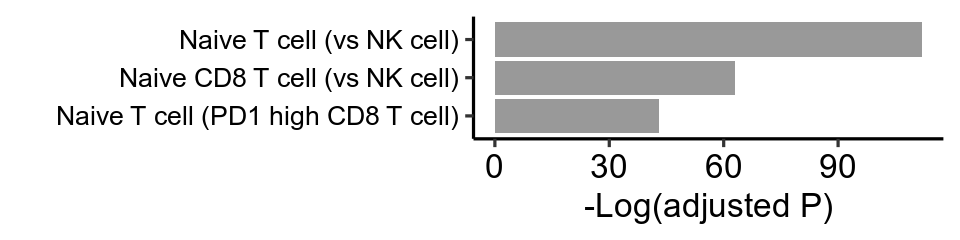

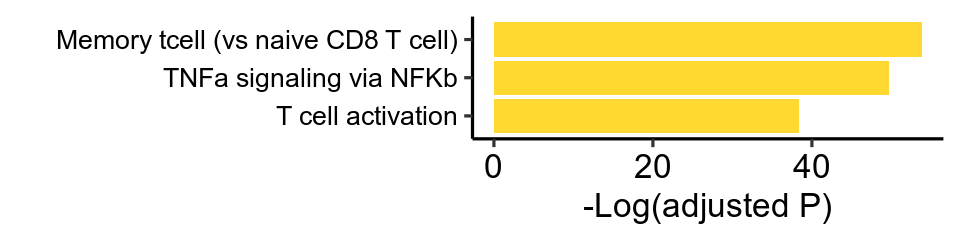

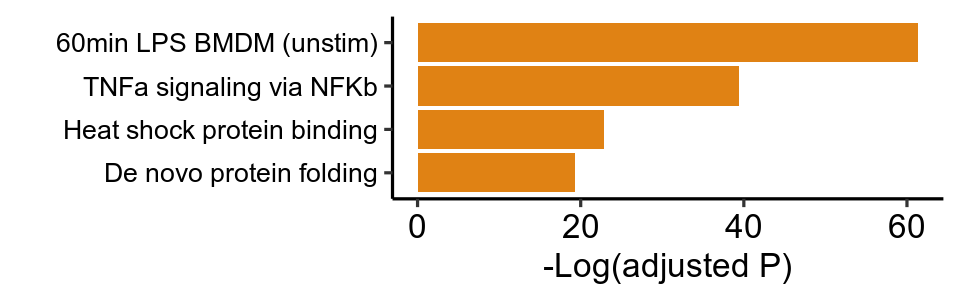

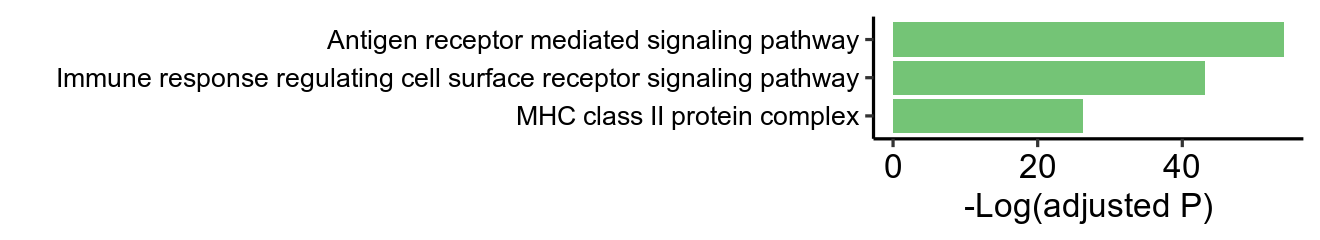

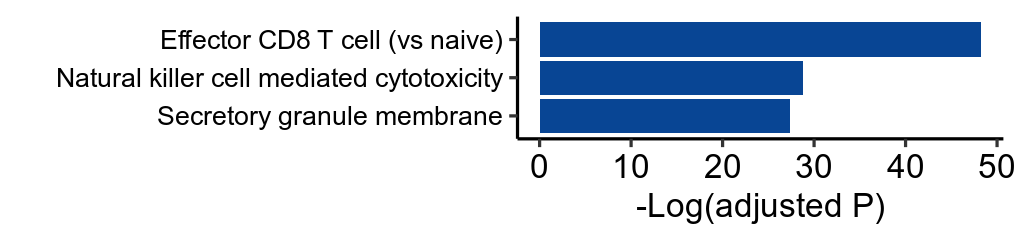

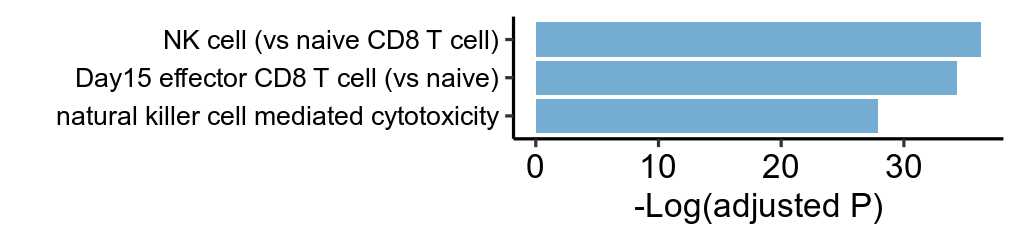

In [497]:

options(repr.plot.height = 2, repr.plot.width = 8)
ggplot(
      pathway_plot[which(pathway_plot$cluster == 1),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster1", ".pdf", sep = ""), width = 8, height = 2, dpi = 300)

ggplot(
      pathway_plot[which(pathway_plot$cluster == 3),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster3", ".pdf", sep = ""), width = 8, height = 2, dpi = 300)


options(repr.plot.height = 2.5, repr.plot.width = 8)
ggplot(
      pathway_plot[which(pathway_plot$cluster == 4),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster4", ".pdf", sep = ""), width = 8, height = 2.5, dpi = 300)


options(repr.plot.height = 2, repr.plot.width = 11)
ggplot(
      pathway_plot[which(pathway_plot$cluster == 5),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster5", ".pdf", sep = ""), width = 11, height = 2, dpi = 300)


options(repr.plot.height = 2, repr.plot.width = 8.5)
ggplot(
      pathway_plot[which(pathway_plot$cluster == 6),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster6", ".pdf", sep = ""), width = 8.5, height = 2, dpi = 300)


ggplot(
      pathway_plot[which(pathway_plot$cluster == 7),],
      aes(x = reorder(brief_annot, log_padjust), y= log_padjust, fill = cluster)
      ) +
#       geom_text(aes(label=brief_annot), position=position_dodge(width=0.75), vjust=0.5, hjust=-0.1, size=5) +
      coord_flip() +
      labs(x = "", y = "-Log(adjusted P)") +
      geom_bar(stat="identity") +
      scale_fill_manual(values = meta_colors$cluster_new, name = "") +
      theme_classic(base_size = 20) +
      theme(
        legend.position = "none",
          axis.text.x = element_text(size = 20),
    #     axis.ticks = element_blank(),
          axis.text = element_text(color = "black"),
        panel.grid = element_blank()
      ) 
ggsave(file = paste("pathway_cluster7", ".pdf", sep = ""), width = 8.5, height = 2, dpi = 300)


pdf 
  3

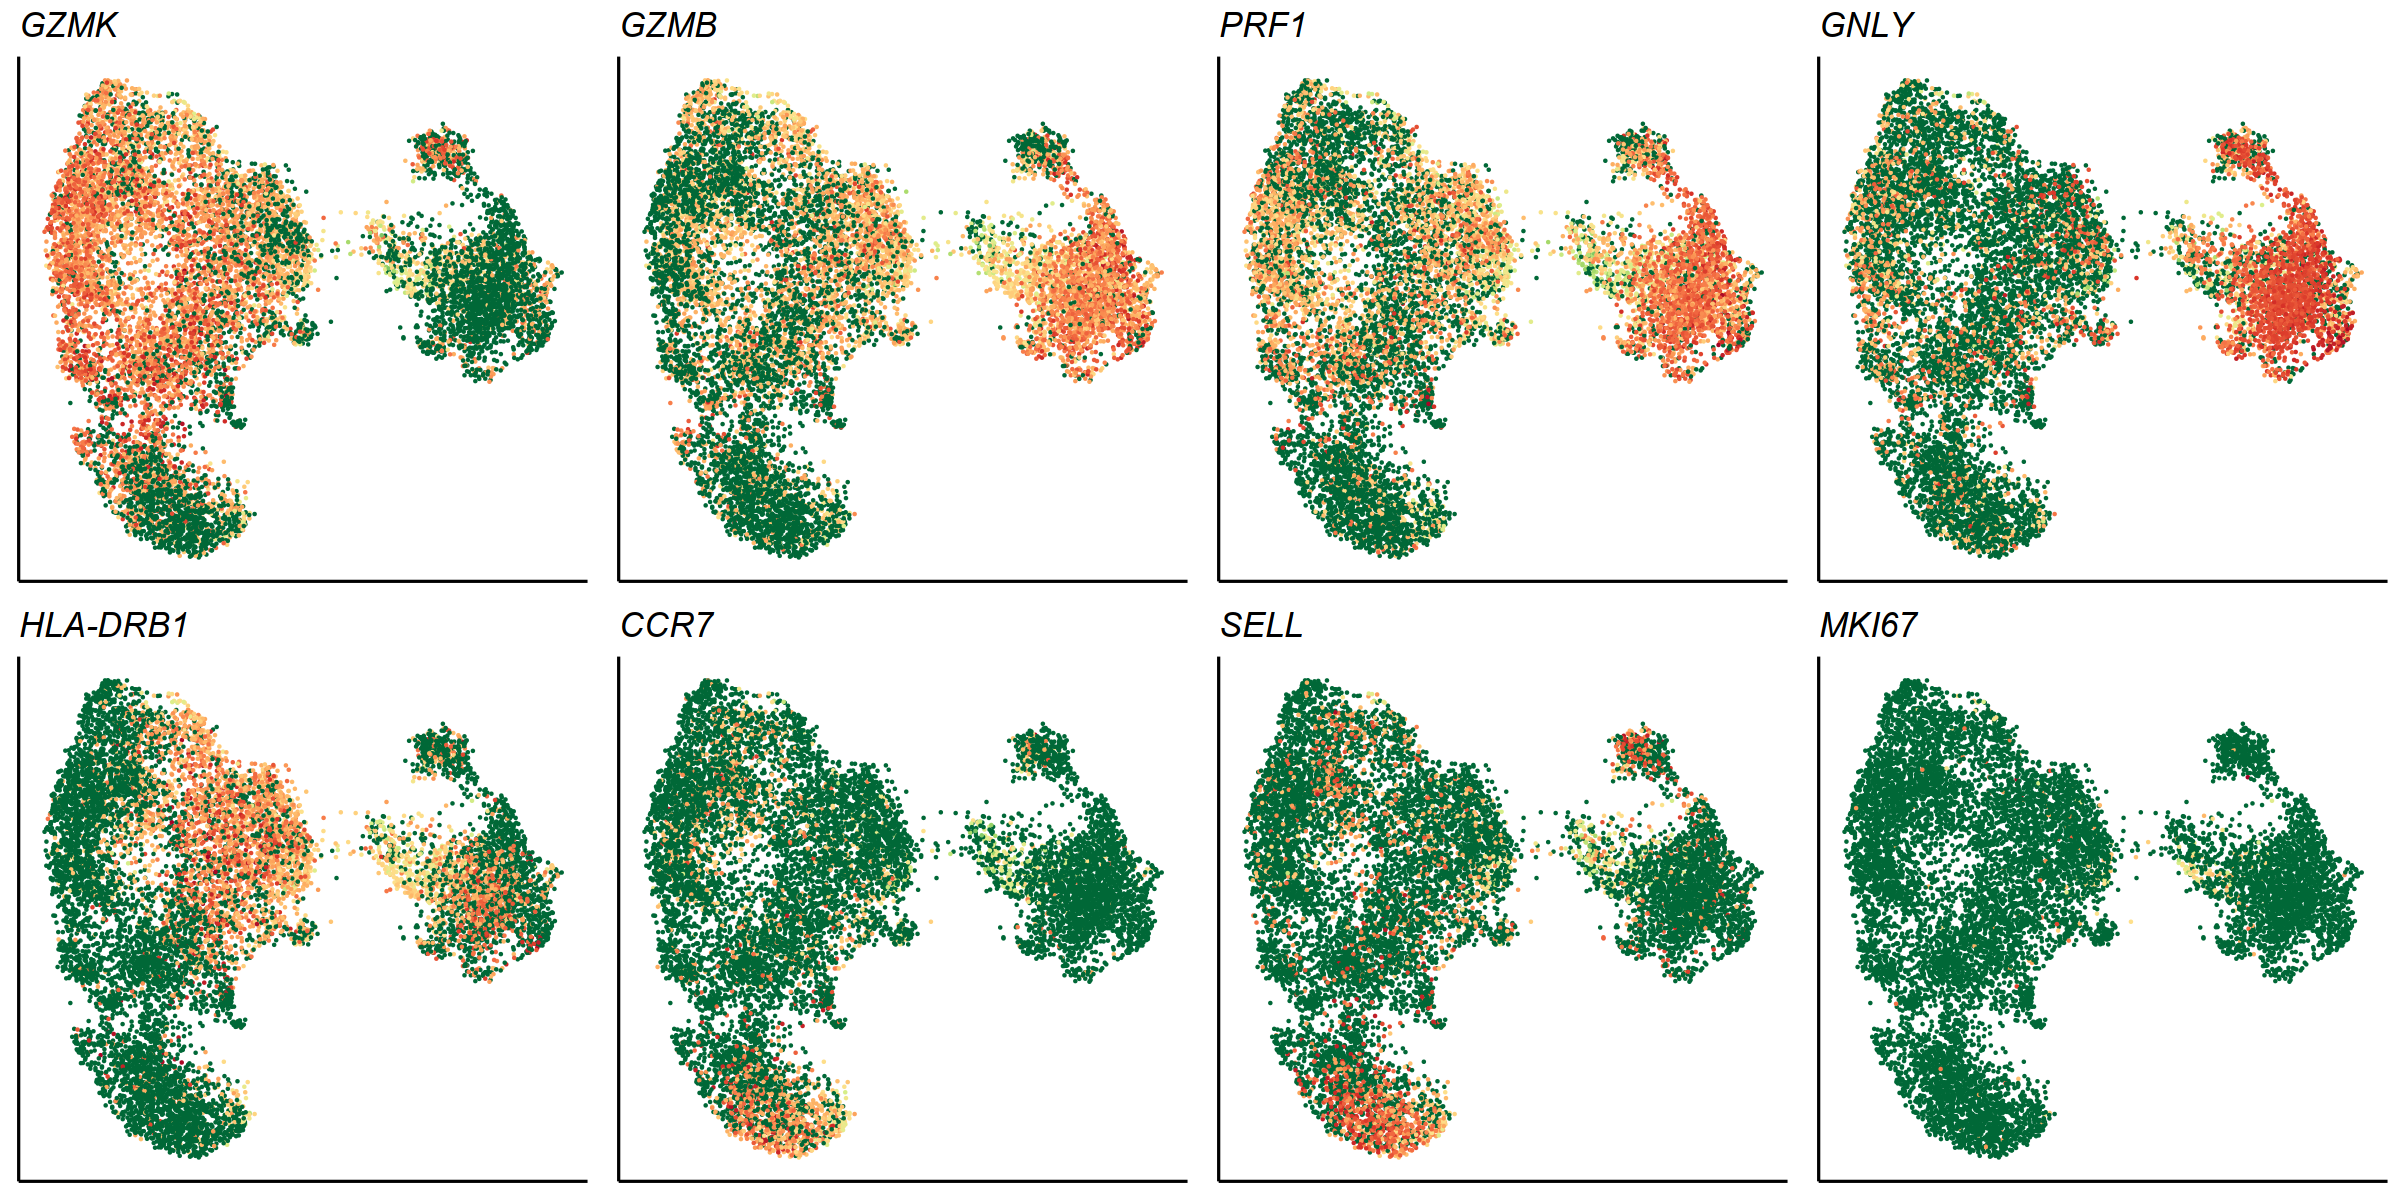

In [51]:
options(repr.plot.height = 10, repr.plot.width = 20)

plot_gene <- c("GZMK", "GZMB", "PRF1", "GNLY", "HLA-DRB1", "CCR7", "SELL", "MKI67")

#                c("GZMK", "GZMB", "CCR7", "HLA-DRB1", "MKI67", "PRF1", "CXCR1", "CXCR3", "SELL", "CD69", 
#                "FGFBP2", "ZNF683", "PDCD1", "HAVCR2", "LAG3")

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
  ind <- paste("p", i, sep = "")
  ind <- ggplot() +
    geom_point(
    data = tis_flui_blov2v3_meta,
#       data = tis_flui_blov2v3_meta[order(tis_flui_blov2v3_meta$gene),],
      mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "gene"),
      size = 1, stroke = 0.001, shape = 21
    ) +
    scale_fill_gradientn(
      colours = colorRampPalette(rev(RColorBrewer::brewer.pal(10, "RdYlGn")))(10),
#       colours = colorRampPalette(rev(RColorBrewer::brewer.pal(9, "Greens")))(9),
      name = bquote("Log"[2]~"(CPM+1)")
    ) +
#     facet_grid( ~ source, scales = "free", space = "free_x") +
    scale_x_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP1), max(tis_flui_blov2v3_meta$UMAP1))) +
    scale_y_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP2), max(tis_flui_blov2v3_meta$UMAP2))) +
    guides(
#       fill = guide_colorbar(barwidth = 1, barheight = 10),
      fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_classic(base_size = 15) +
    theme(
      plot.title = element_text(color="black", size=20, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("tis_flui_blov2v3_marker", ".png", sep = ""), p, width = 15, height = 10, dpi = 300)
dev.off()

In [61]:
tis_flui_blov2v3_meta$source <- as.character(tis_flui_blov2v3_meta$dataset)
tis_flui_blov2v3_meta$source[which(tis_flui_blov2v3_meta$source %in% c("amp phase I", "bwh002", "bwh054", "bwh075", "bwh076"))] <- "tissue"
tis_flui_blov2v3_meta$source[which(tis_flui_blov2v3_meta$source %in% c("PBMC_v2 (ITC)", "PBMC_v3"))] <- "PBMC"
tis_flui_blov2v3_meta$source <- factor(tis_flui_blov2v3_meta$source, levels = c("tissue", "fluid", "PBMC"))

null device 
          1

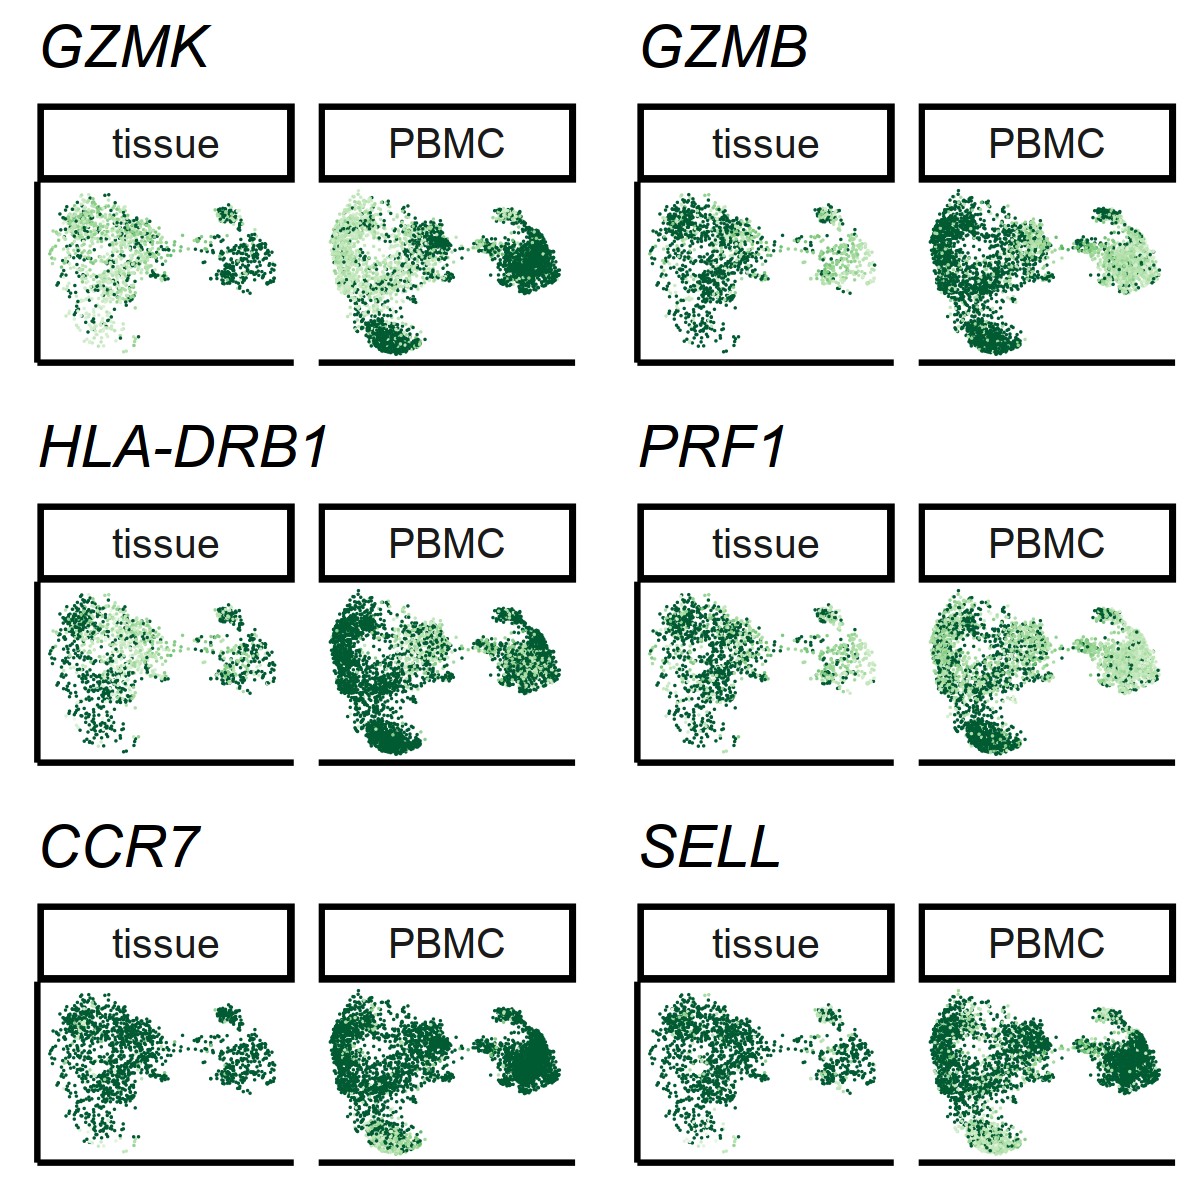

In [21]:
options(repr.plot.height = 10, repr.plot.width = 10)

plot_gene <- c("GZMK", "GZMB", "HLA-DRB1", "PRF1", "CCR7", "SELL")

#                c("GZMK", "GZMB", "CCR7", "HLA-DRB1", "MKI67", "PRF1", "CXCR1", "CXCR3", "SELL", "CD69", 
#                "FGFBP2", "ZNF683", "PDCD1", "HAVCR2", "LAG3")

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
    
  temp <- tis_flui_blov2v3_meta[-which(tis_flui_blov2v3_meta$dataset == "fluid"),]
    
  ind <- paste("p", i, sep = "")
  ind <- ggplot() +
    geom_point(
    data = temp[sample(nrow(temp)),],
#       data = tis_flui_blov2v3_meta[order(tis_flui_blov2v3_meta$gene),],
      mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "gene"),
      size = 0.7, stroke = 0.001, shape = 21
    ) +
    scale_fill_gradientn(
#       colours = colorRampPalette(rev(RColorBrewer::brewer.pal(10, "RdYlGn")))(10),
      colours = colorRampPalette(rev(RColorBrewer::brewer.pal(7, "Greens")))(9),
      name = bquote("Log"[2]~"(CPM+1)")
    ) +
    facet_grid( ~ source, scales = "free", space = "free_x") +
    scale_x_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP1), max(tis_flui_blov2v3_meta$UMAP1))) +
    scale_y_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP2), max(tis_flui_blov2v3_meta$UMAP2))) +
    guides(
      fill = guide_colorbar(barwidth = 1, barheight = 10),
#       fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_classic(base_size = 30) +
    theme(
      legend.position = "none",
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 2))
ggsave(file = paste("tis_flui_blov2v3_marker_tissue_v2", ".png", sep = ""), p, width = 10, height = 10, dpi = 300)
dev.off()

Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”


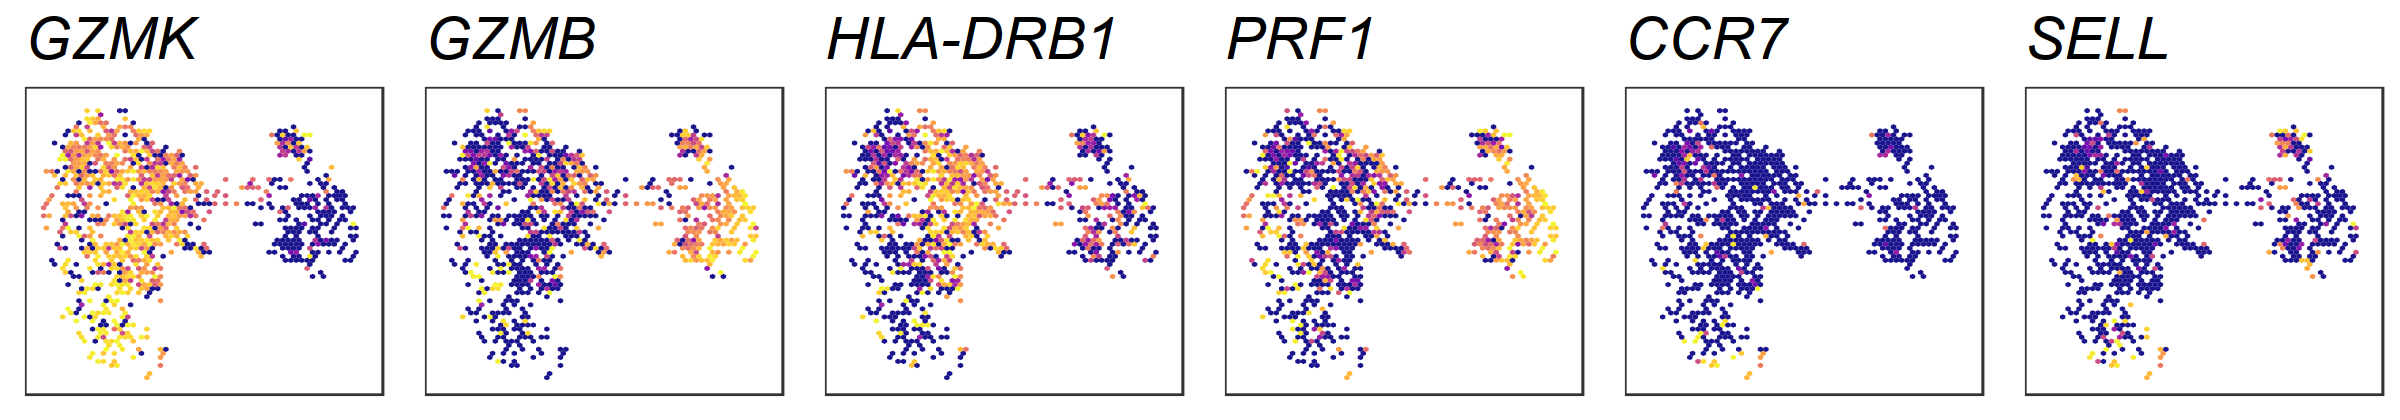

Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”
Warning message:
“Removed 1 rows containing missing values (geom_hex).”


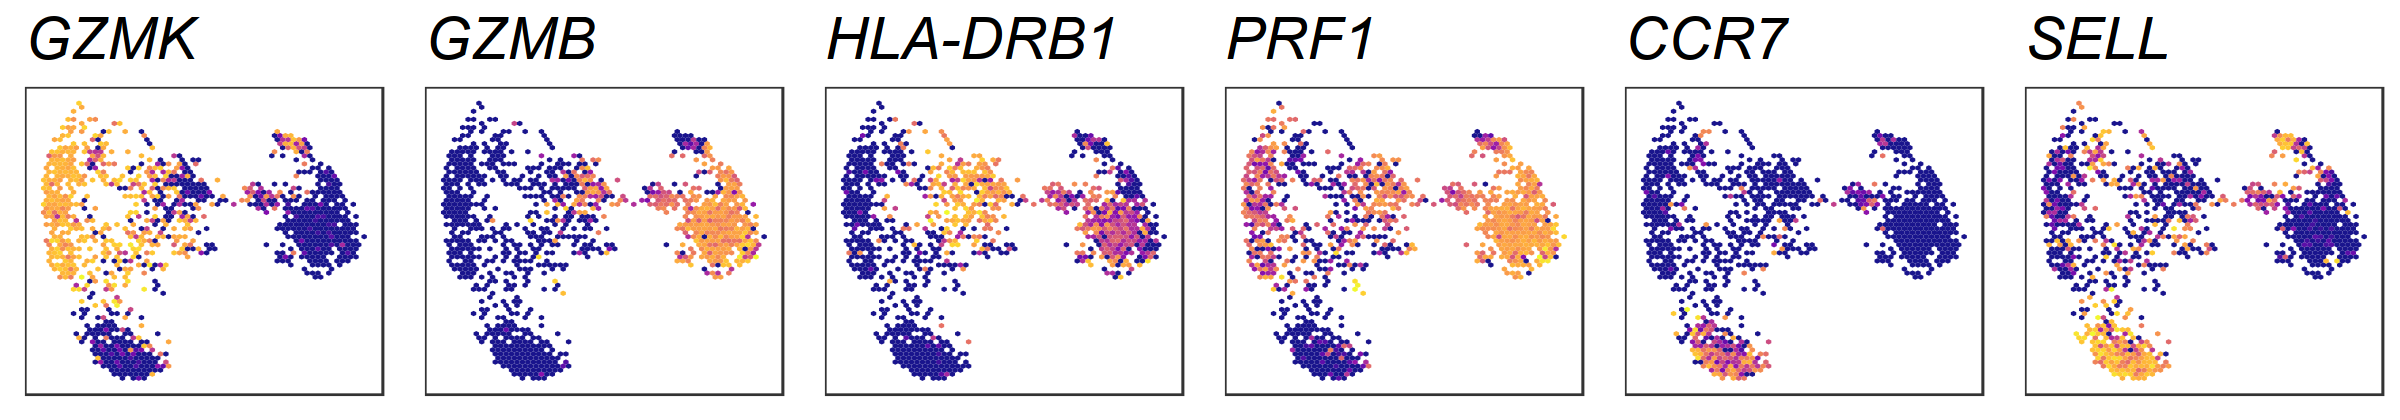

pdf 
  3

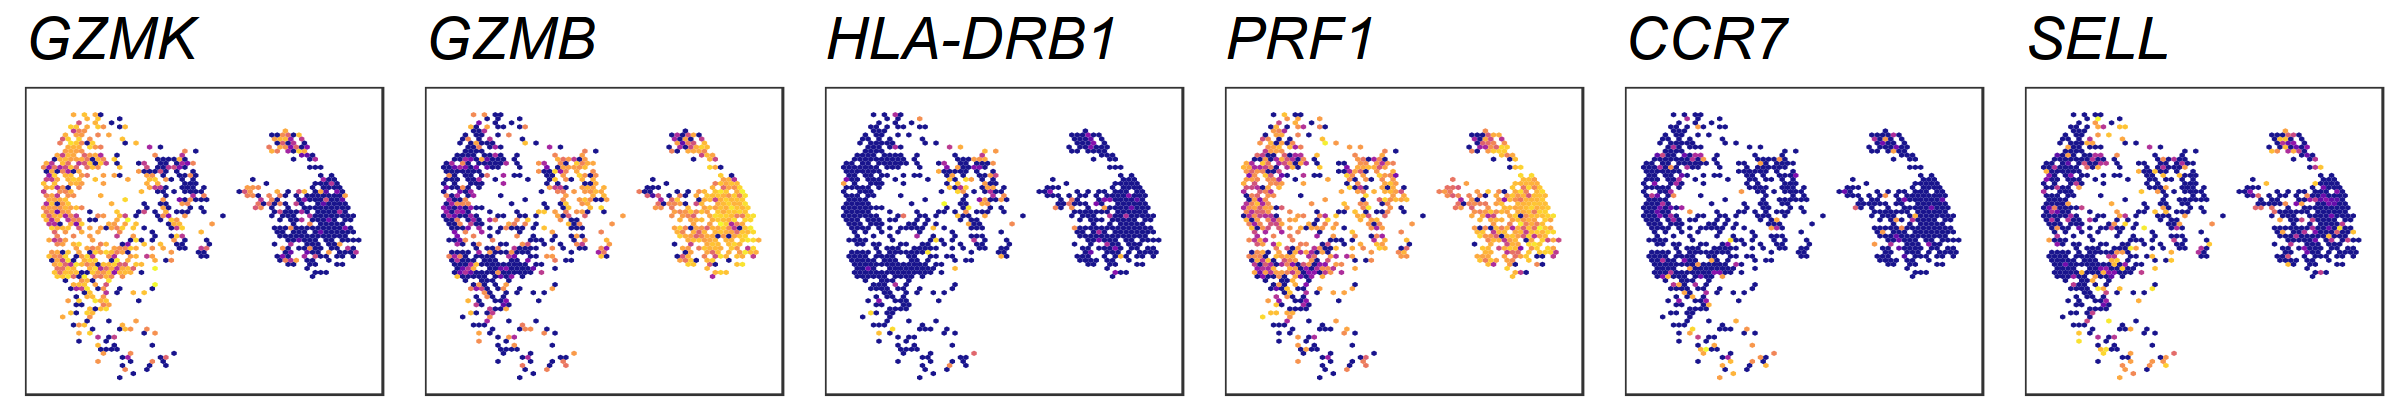

In [66]:
plot_gene <- c("GZMK", "GZMB", "HLA-DRB1", "PRF1", "CCR7", "SELL")
options(repr.plot.height = 3.5, repr.plot.width = 20)

# Tissue -------------------------------------------------------------------------------------------------------------------------------------------------

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
    
  temp <- tis_flui_blov2v3_meta[which(tis_flui_blov2v3_meta$source == "tissue"),]
    

    
    
  ind <- paste("p", i, sep = "")
  ind <- ggplot() +
        
    ggplot(temp[sample(nrow(temp)),]) +
    stat_summary_hex(aes(x = UMAP1, y = UMAP2, z = gene ),
                     fun = mean,
                     bins = 60, alpha = 0.95,
                     data = temp) +
    scale_fill_viridis(option = "plasma") +
         
    
    scale_x_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP1), max(tis_flui_blov2v3_meta$UMAP1))) +
    scale_y_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP2), max(tis_flui_blov2v3_meta$UMAP2))) +
    guides(
      fill = guide_colorbar(barwidth = 1, barheight = 10),
#       fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_bw(base_size = 20) +
    theme(
      legend.position = "none",
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 6))
ggsave(file = paste("1", ".png", sep = ""), p, width = 20, height = 3.5, dpi = 400)
# dev.off()



# PBMC -------------------------------------------------------------------------------------------------------------------------------------------------

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
    
  temp <- tis_flui_blov2v3_meta[which(tis_flui_blov2v3_meta$dataset == "PBMC_v3"),]
    
  ind <- paste("p", i, sep = "")
  ind <- ggplot() +
    ggplot(temp[sample(nrow(temp)),]) +
    stat_summary_hex(aes(x = UMAP1, y = UMAP2, z = gene ),
                     fun = mean,
                     bins = 60, alpha = 0.95,
                     data = temp) +
    scale_fill_viridis(option = "plasma") +
         
    scale_x_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP1), max(tis_flui_blov2v3_meta$UMAP1))) +
    scale_y_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP2), max(tis_flui_blov2v3_meta$UMAP2))) +
    guides(
      fill = guide_colorbar(barwidth = 1, barheight = 10),
#       fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_bw(base_size = 20) +
    theme(
      legend.position = "none",
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 6))
ggsave(file = paste("2", ".png", sep = ""), p, width = 20, height = 3.5, dpi = 400)
# dev.off()


# # ITC -------------------------------------------------------------------------------------------------------------------------------------------------

temp_exp <- tis_flui_blov2v3_exp[, which(colnames(tis_flui_blov2v3_exp) %in% tis_flui_blov2v3_meta_itc$name)]

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta_itc$gene <- as.numeric(temp_exp[which(rownames(temp_exp) == gene),])
  temp <- tis_flui_blov2v3_meta_itc[-which(tis_flui_blov2v3_meta_itc$cell.type == "CD8"),]
  
  ind <- paste("p", i, sep = "")
  ind <- ggplot() +
     ggplot(temp[sample(nrow(temp)),]) +
    stat_summary_hex(aes(x = UMAP1, y = UMAP2, z = gene ),
                     fun = mean,
                     bins = 60, alpha = 0.95,
                     data = temp) +
    scale_fill_viridis(option = "plasma") +
    scale_x_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP1), max(tis_flui_blov2v3_meta$UMAP1))) +
    scale_y_continuous(limits = c(min(tis_flui_blov2v3_meta$UMAP2), max(tis_flui_blov2v3_meta$UMAP2))) +
    guides(
      fill = guide_colorbar(barwidth = 1, barheight = 7.5),
#       fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_bw(base_size = 20) +
    theme(
      legend.position = "none",
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 6))
ggsave(file = paste("3", ".png", sep = ""), p, width = 20, height = 3.5, dpi = 400)
dev.off()

In [95]:
tis_meta_violin <- tis_flui_blov2v3_meta[which(tis_flui_blov2v3_meta$dataset %in% c("amp phase I", "bwh002", "bwh054", "bwh075", "bwh076")),]
tis_exp_violin <- tis_flui_blov2v3_exp[, which(colnames(tis_flui_blov2v3_exp) %in% tis_meta_violin$name)]
all(colnames(tis_exp_violin) == tis_meta_violin$name)
dim(tis_exp_violin)

tis_meta_violin$megacluster <- tis_meta_violin$cluster_new
tis_meta_violin$megacluster[which(tis_meta_violin$megacluster %in% c(6,7))] <- "GzmB+"
tis_meta_violin$megacluster[which(tis_meta_violin$megacluster %in% c(2,3,4,5))] <- "GzmK+"
tis_meta_violin$megacluster[which(tis_meta_violin$megacluster %in% c(1))] <- "Naive"
table(tis_meta_violin$megacluster, tis_meta_violin$dataset)

[1] TRUE

[1] 11807  1495

       
        amp phase I bwh002 bwh054 bwh075 bwh076
  GzmB+         103     48     45     78     75
  GzmK+         323    231     90    203    201
  Naive           2     30     12     22     32

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”
Warning message:
“Ignoring unknown parameters: shape, stroke, gr

pdf 
  3

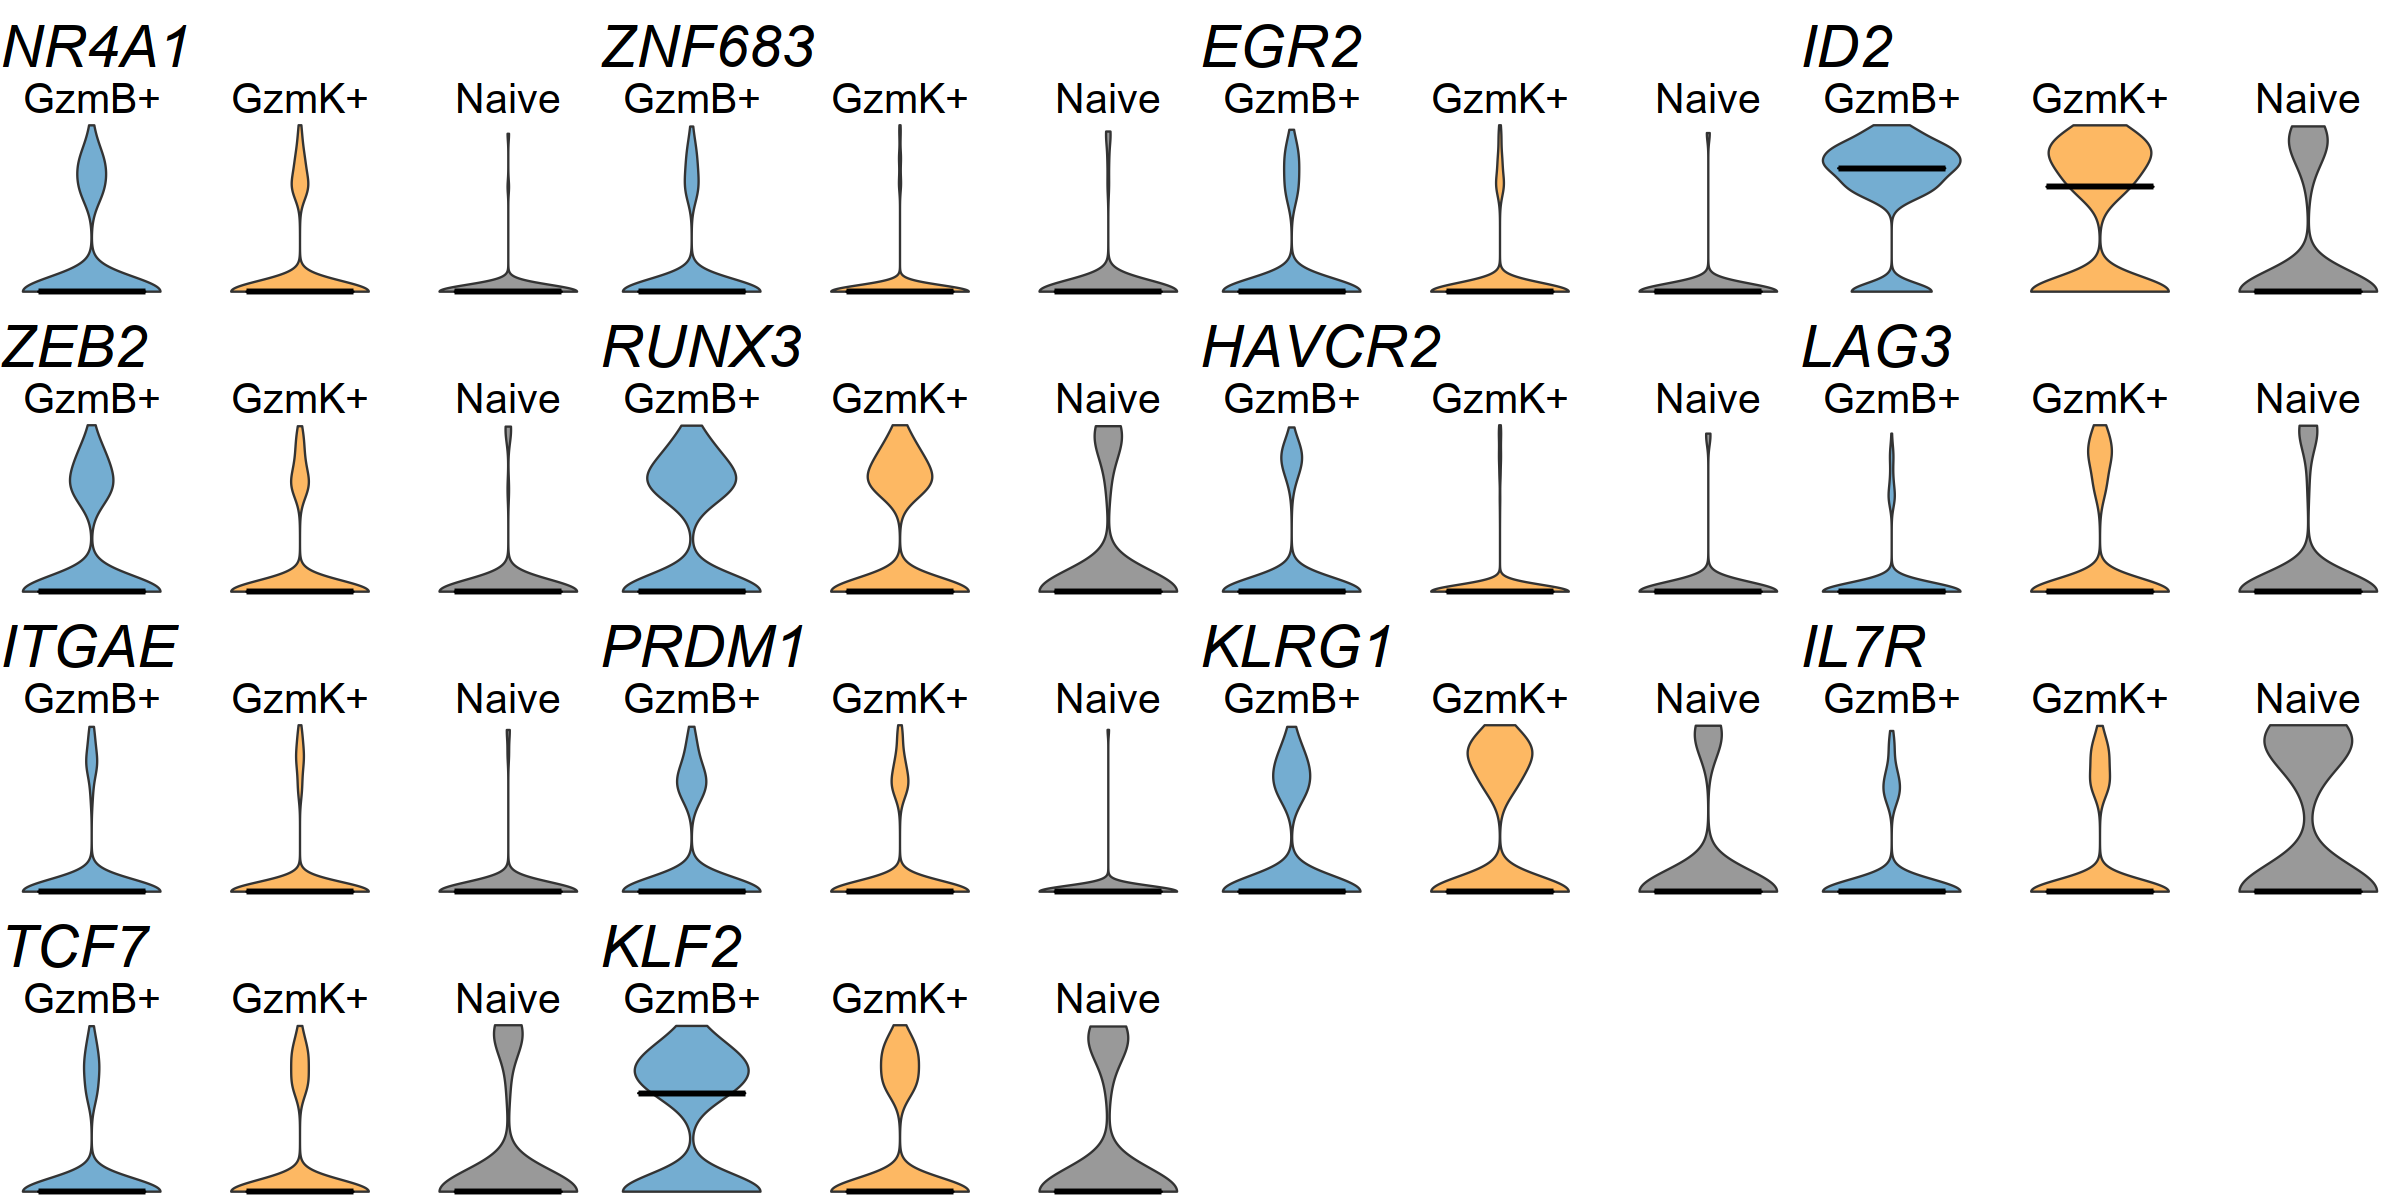

In [278]:
library(ggbeeswarm)

# Curated gene set from Helena
curate_g <- c("NR4A1", "ZNF683","EGR2", "ID2", "ZEB2", "RUNX3", "HAVCR2", "LAG3", "ITGAE", "PRDM1", "KLRG1", "IL7R", "TCF7", "KLF2")

# curate_g <- c("TOX2", "NR4A1", "LILRB1", "ZNF683", "ENTPD1", "EGR2", "TNFRSF1B", "ID2", "GNLY", "ZEB2", "RUNX3", "TBX21", "CDKN2A", "B3GAT1", "HAVCR2", "GZMB",
#              "FASLG", "HLA-DRB1", "LAG3", "MKI67", "ITGAE", "TNF", "PRDM1", "PRF1", "IFNG", "KLRG1", "EOMES", "TOX", "CD69", "PDCD1", "ZEB1", "ICOS", "FOXO1", "SELL",
#              "S1PR1", "STAT3", "IL7R", "TCF7", "KLF2", "GZMK", "TNFSF13B", "CCL4", "CCL5", "TNFRSF1A")
curate_g %in% rownames(tis_exp_violin)

myplots <- list()
options(repr.plot.height = 10, repr.plot.width = 20)
for (i in 1:length(curate_g)) {
  gene <- curate_g[i]
  tis_meta_violin$gene <- as.numeric(tis_exp_violin[which(rownames(tis_exp_violin) == gene),])
    
  ind <- paste("p", i, sep = "")
  ind <- 
    ggplot(
      data    = tis_meta_violin,
#       data    = subset(tis_meta_violin, gene > 0),
      mapping = aes(x = megacluster, y = gene, fill = megacluster)
    ) +
    geom_violin(
      shape = 21, stroke = 0.01, size = 0.5, grouponX= TRUE
    ) +
    stat_summary(
       fun = median, fun.min = median, fun.max = median,
       geom = "crossbar", width = 0.7, size = 0.5
    ) +
    scale_fill_manual("", values = c("#74ADD1", "#FDB863", "#999999")) +
    facet_grid( ~ megacluster, scales = "free", space = "free_x") + 
#     scale_y_continuous(limits = c(0, max(tis_flui_blov2v3_meta$gene))) +
    guides(
      fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_void(base_size = 30) +
    theme(
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
#       axis.text = element_blank(), 
#       axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}


all <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("tis_curated_gene_violin", ".png", sep = ""), all, width = 30, height = 20, dpi = 300)
dev.off()

Warning message:
“Ignoring unknown parameters: grouponX”
Warning message:
“Ignoring unknown parameters: grouponX”
Warning message:
“Ignoring unknown parameters: grouponX”
Warning message:
“Ignoring unknown parameters: grouponX”
Warning message:
“Ignoring unknown parameters: grouponX”
Warning message:
“Ignoring unknown parameters: grouponX”


null device 
          1

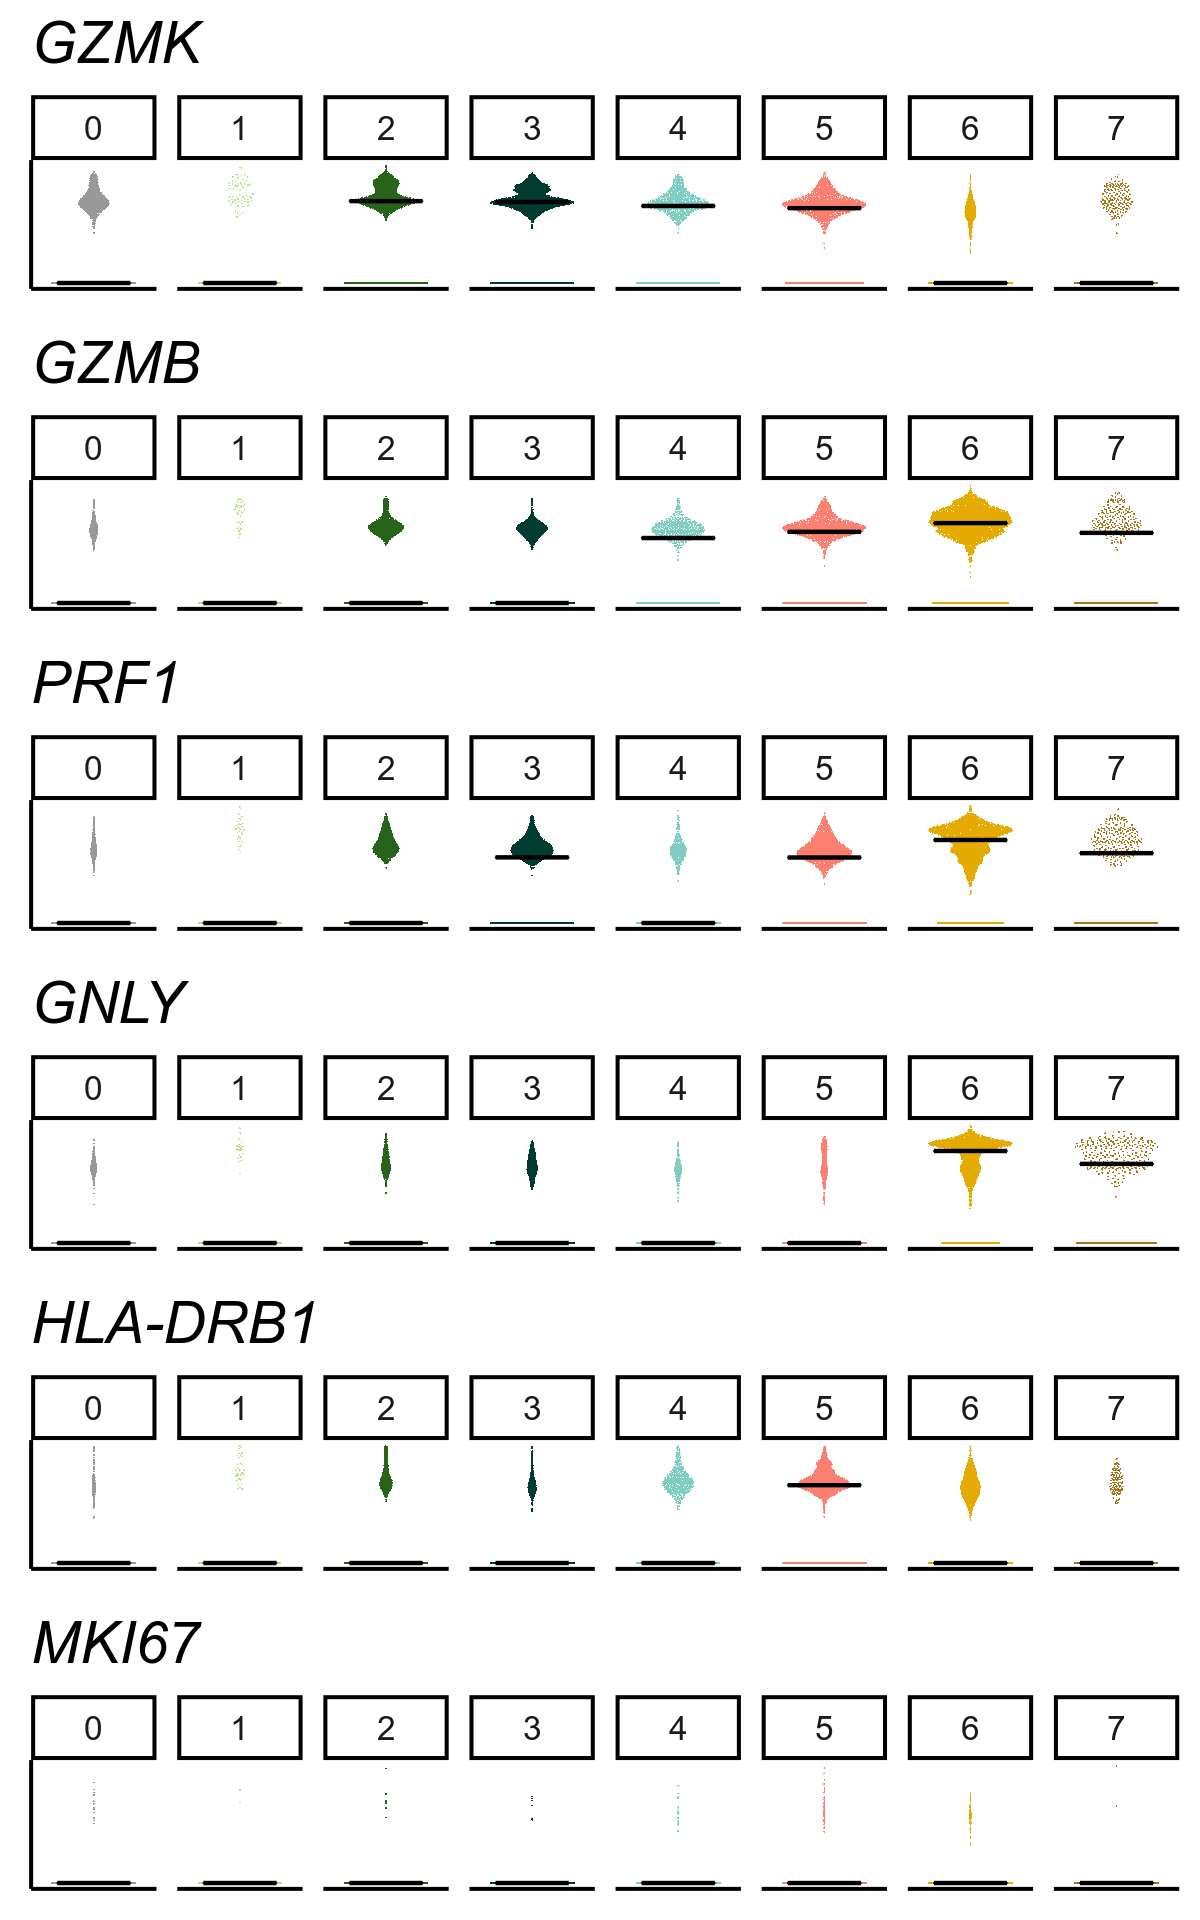

In [13]:
library(ggbeeswarm)
myplots <- list()

plot_gene <- c("GZMK", "GZMB", "PRF1", "GNLY", "HLA-DRB1", "MKI67")

options(repr.plot.height = 16, repr.plot.width = 10)
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  tis_flui_blov2v3_meta$gene <- as.numeric(tis_flui_blov2v3_exp[which(rownames(tis_flui_blov2v3_exp) == gene),])
    
  ind <- paste("p", i, sep = "")
  ind <- 
    ggplot(
      data    = tis_flui_blov2v3_meta,
#       data    = subset(tis_flui_blov2v3_meta, gene > 0),
      mapping = aes(x = cluster_new, y = gene, fill = cluster_new)
    ) +
    geom_quasirandom(
      shape = 21, stroke = 0.01, size = 0.5, grouponX= TRUE
    ) +
    stat_summary(
       fun.y = median, fun.ymin = median, fun.ymax = median,
       geom = "crossbar", width = 0.7, size = 0.5
    ) +
    scale_fill_manual("", values = meta_colors$cluster) +
    facet_grid( ~ cluster_new, scales = "free", space = "free_x") + 
#     scale_y_continuous(limits = c(0, max(tis_flui_blov2v3_meta$gene))) +
    guides(
      fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_classic(base_size = 25) +
    theme(
      plot.title = element_text(color="black", size=35, face = "italic"), # face="bold.italic"
      axis.text = element_blank(), 
      axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
  myplots[[i]] <- ind
}


all <- do.call("grid.arrange", c(myplots, ncol = 1))
ggsave(file = paste("tis_flui_blov2v3_markers_beeswarm", ".png", sep = ""), all, width = 10, height = 16, dpi = 300)
dev.off()

null device 
          1

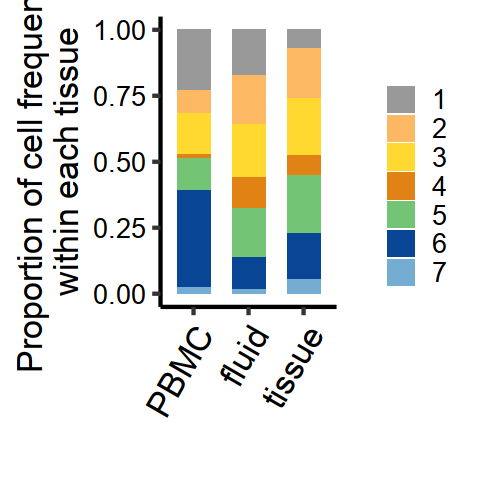

In [39]:
# tis_flui_blov3_meta <- tis_flui_blov2v3_meta[-which(tis_flui_blov2v3_meta$dataset == "PBMC_v2 (ITC)"),]
cd8_name <- tis_flui_blov2v3_meta_itc[which(tis_flui_blov2v3_meta_itc$cell.type == "CD8"),]$name
tis_flui_blov2cd8_meta <- tis_flui_blov2v3_meta[which(tis_flui_blov2v3_meta$name %in% cd8_name),]
tis_flui_blov3_blov2cd8 <- rbind(tis_flui_blov3_meta, tis_flui_blov2cd8_meta)

temp5 <- table(tis_flui_blov3_blov2cd8$cluster_new, tis_flui_blov3_blov2cd8$source)

temp6 <- melt(temp5)
colnames(temp6) <- c("cluster", "tissue", "freq")

hc1 <- hclust(dist(temp5))
temp6$cluster <- as.factor(temp6$cluster)

temp6$tissue <- factor(temp6$tissue, levels = c("PBMC", "fluid", "tissue")
                      )           

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(
      temp6,
      aes(x = tissue, y=freq, fill = cluster)
      ) + 
    geom_bar(stat = "identity", 
             position = "fill", 
             width = 0.6) +
    scale_fill_manual("", values = meta_colors$cluster_new) +
    labs(x = "", y = "Proportion of cell frequency \nwithin each tissue") + 
  theme_classic(base_size = 20) +
  theme(
      axis.text.x = element_text(angle = 60, hjust = 1, size = 20),
      axis.text = element_text(color = "black"),
      panel.grid = element_blank(),
      plot.title = element_text(color="black", size=20, face = "italic")
  ) 
ggsave(file = paste("tis_flui_blov3_blov2cd8_barplot", ".pdf", sep = ""), width = 8, height = 8, dpi = 300)
dev.off()